In [14]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats import f
from calendar import day_abbr
import locale
import os
from my_functions import DST_trafo
import seaborn as sns
import statsmodels.api as sm
#import glmnet
from sklearn.preprocessing import StandardScaler
#from glmnet import ElasticNet
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from forecast_functions import *
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from bspline import Bspline
from scipy.stats import ttest_rel

In [15]:
data= pd.read_csv("FR_price.csv") #final dataset after remove unrelavant predictors and drop outlier

In [16]:
data

DateTime  FR_Price_DA  FR_Load_DA  FR_Nuclear_Output  \
0      2015-01-04T23:00:00Z        36.56       62.90             56.499   
1      2015-01-05T00:00:00Z        34.94       60.25             57.024   
2      2015-01-05T01:00:00Z        32.19       59.65             57.350   
3      2015-01-05T02:00:00Z        23.53       56.50             55.512   
4      2015-01-05T03:00:00Z        22.92       55.05             54.950   
...                     ...          ...         ...                ...   
76626  2023-10-02T17:00:00Z       182.02       49.15             37.705   
76627  2023-10-02T18:00:00Z       160.07       49.30             36.763   
76628  2023-10-02T19:00:00Z       120.00       45.65             36.477   
76629  2023-10-02T20:00:00Z       103.25       43.85             36.675   
76630  2023-10-02T21:00:00Z       100.00       45.50             36.923   

       FR_HydroWater_Output  FR_Gas_Output  FR_Oil_Output  FR_Residual_Load  \
0                     0.819          2.435          0.261          61.48123   
1                     0.714          2.451          0.261          58.84145   
2                     0.624          2.456          0.262          58.36858   
3                     0.515          2.481          0.261          55.34581   
4                     0.481          2.654          0.261          54.02193   
...                     ...            ...            ...               ...   
76626                 2.252          3.571          0.143          43.64310   
76627                 2.614          3.542          0.143          43.37417   
76628                 2.183          3.107          0.143          38.74269   
76629                 1.663          3.153          0.143          35.96108   
76630                 1.003          2.713          0.143          36.62941   

       DE_Price_DA  DE_Load_DA  ...  IT_Load_DA  BE_Load_DA  Coal_fM  Coal_fQ  \
0            22.34    43.17617  ...      11.161     9.74709    53.43    52.58   
1            17.93    41.59758  ...      10.375     9.56003    52.74    51.69   
2            15.17    40.42159  ...      10.085     9.08613    52.74    51.69   
3            16.38    40.40436  ...       9.946     8.78327    52.74    51.69   
4            17.38    41.34813  ...      10.034     8.65436    52.74    51.69   
...            ...         ...  ...         ...         ...      ...      ...   
76626       245.05    55.17198  ...      21.410     9.94580      NaN      NaN   
76627       160.07    53.21370  ...      20.445     9.69598      NaN      NaN   
76628       120.00    49.83315  ...      19.065     9.31059      NaN      NaN   
76629       107.03    45.10129  ...      17.258     8.85516      NaN      NaN   
76630       100.00    42.07174  ...      16.028     8.41301      NaN      NaN   

       Coal_fY  Gas_fD  Gas_fM  Gas_fQ  Gas_fY  Oil_fM  
0        51.97    19.8   20.14   19.68   20.40   44.51  
1        51.30    19.2   19.54   19.09   20.03   42.98  
2        51.30    19.2   19.54   19.09   20.03   42.98  
3        51.30    19.2   19.54   19.09   20.03   42.98  
4        51.30    19.2   19.54   19.09   20.03   42.98  
...        ...     ...     ...     ...     ...     ...  
76626      NaN     NaN     NaN     NaN     NaN     NaN  
76627      NaN     NaN     NaN     NaN     NaN     NaN  
76628      NaN     NaN     NaN     NaN     NaN     NaN  
76629      NaN     NaN     NaN     NaN     NaN     NaN  
76630      NaN     NaN     NaN     NaN     NaN     NaN  

[76631 rows x 24 columns]

## Lasso and Ridge Regression

In [ ]:

# Setup local time, language
locale.setlocale(locale.LC_ALL, 'EN_US')
locale.getlocale()
data["DateTime"]= pd.to_datetime(data["DateTime"],
                           utc=True, format="%Y-%m-%dT%H:%M:%SZ")
# Extract price data
price = data.loc[:, "FR_Price_DA"]
time_utc = pd.to_datetime(data["DateTime"],
                          utc=True, format="%Y-%m-%d %H:%M:%S")
local_time_zone = "CET"
time_lt = time_utc.dt.tz_convert(local_time_zone)

S = 24
# %% Save the start and end-time
start_end_time_S = time_lt.iloc[[0, -1]
                                ].dt.tz_localize(None).dt.tz_localize("UTC")
# %% creating 'fake' local time
start_end_time_S_num = pd.to_numeric(start_end_time_S)
time_S_numeric = np.arange(
    start=start_end_time_S_num.iloc[0],
    stop=start_end_time_S_num.iloc[1] + 24 * 60 * 60 * 10 ** 9 / S,
    step=24 * 60 * 60 * 10 ** 9 / S,
)
# %% 'fake' local time
time_S = pd.Series(pd.to_datetime(time_S_numeric, utc=True))
dates_S = pd.Series(time_S.dt.date.unique())
# %% import DST_trafo function and use it on data
data_array = DST_trafo(X=data.iloc[:, 1:], Xtime=time_utc, tz=local_time_zone)
data_array.shape
# %% save as dataframe
price_S = pd.DataFrame(data_array[..., 0], index=dates_S)
reg_names = data.columns[1:]
data.iloc[:, 1:].head()

In [ ]:
# Extract price data
price = data.loc[:, "FR_Price_DA"]

# Create Plotly figure
fig = go.Figure()

# Add line trace
fig.add_trace(go.Scatter(x=time_utc, y=data.iloc[:, 1], mode='lines', name='Price'))

# Update layout
fig.update_layout(
    title='Price Over Time',
    xaxis_title='Time',
    yaxis_title='Price in EUR/MWh',
    template='plotly',  # Use a dark theme, you can choose another template if you prefer
    showlegend=True
)

# Show the interactive plot
fig.show()

In [24]:
N_test = 365 # testing size 1*365*24
D = 365 * 5  # 5 years training
N = price_S.shape[0] - D - N_test  # validation window
N_test = price_S.shape[0] - D - N  # testing window

training_set = price_S.iloc[:D]
validation_set = price_S.iloc[D:D + N]
testing_set = price_S.iloc[D + N:]
oos_dates = dates_S[D:N+D]
oos_dates_test = dates_S[D + N:]
model_names = ["true", "naive", "expert", "lasso", "ridge", "elastic"]
number_of_models = len(model_names)
expert_wd = [1, 6, 7]
expert_lags = [1, 2, 7]

fuel_lags=[2]
output_lags=[1]
lambdas = 2**(np.linspace(2, -10, 100))
# create the empty array (3D in here) to store the forecast. 
forecasts = np.full((N, S, number_of_models), np.nan)
dim_names = [oos_dates.values, np.arange(S), model_names]

forecasts_test = np.full((N_test, S, number_of_models), np.nan)
dim_names_tets = [oos_dates_test.values, np.arange(S), model_names]

### Naive model

In [25]:
def forecast_naive(Y, days):
    weekday = (days.iloc[-1] + pd.DateOffset(1)
               ).weekday() + 1  # 1 - Mon, ... , 7 - Sun
    if weekday in [1, 6, 7]:  # if Mon, Sat, Sun, use the previous week
        forecast = Y.values[-7]
    else: 
        forecast = Y.values[-1]
    return {"forecasts": forecast, "coefficients": None}

for n in range(N):
    Y = price_S.iloc[n:D+n]
    days = pd.to_datetime(dates_S[n:D+n], utc=True)

    fc_naive = forecast_naive(Y=Y, days=days) #naive
    forecasts[n, :, 1] = fc_naive["forecasts"]


    print("\r-> "+str(np.round((n+1)/N*100, 4))+"% done", end='')

-> 100.0% donene

## Expert model

In [26]:
def forecast_expert(Y, days, expert_wd=[1, 6, 7], expert_lags=[1, 2, 7]):
    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1),
                                          index=[len(days)])))
    # preparation of weekday dummies including the day to forecast
    weekdays_num = days_ext.dt.weekday+1  # 1 = Mon, 2 = Tue, ..., 7 = Sun
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:, ]

    # preparation of lags :
    def get_lagged(lag, Z):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1-lag)]))

    coefs = np.empty((S, len(expert_wd)+len(expert_lags)+1))

    for s in range(S):
        # prepare the Y vector
        YREG = Y.iloc[:, s].values

        # get lags
        XLAG = np.transpose([get_lagged(lag=lag, Z=YREG)
                            for lag in expert_lags])

        # combine to X matrix
        XREG = np.column_stack((np.ones(Y.shape[0]+1), WD, XLAG))

        act_index = ~ np.isnan(XREG).any(axis=1)
        act_index[-1] = False  # no NAs and no last obs
        model = LinearRegression(fit_intercept=False).fit(
            X=XREG[act_index], y=YREG[act_index[:-1]])

        forecast[s] = model.coef_ @ XREG[-1]
        coefs[s] = model.coef_

    regressor_names = ["intercept"]+[
        day_abbr[i-1]
        for i in expert_wd]+["lag "+str(lag)
                             for lag in expert_lags]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df}

In [27]:
for n in range(N):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    fc_expert = forecast_expert(Y=Y, days=days, expert_wd=expert_wd,
                                expert_lags=expert_lags)
    forecasts[n, :, 2] = fc_expert["forecasts"]

    print("\r-> "+str(np.round((n+1)/N*100, 4))+"% done", end='')


-> 100.0% donene

### Function for LASSO

In [28]:

def forecast_lasso(Y, days, expert_wd, expert_lags, lambdas, fuel_lags, output_lags, index):
    index_ext = np.append(index, index[-1] +1)
    
    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1), index=[len(days)])))
    weekdays_num = days_ext.dt.weekday + 1
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:,]

    def get_lagged(Z, lag):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1 - lag)]))
    
    xprice_temp = np.column_stack([
        data_array[index, S-1, reg_names == "FR_Price_DA"],#last hour (S-1)
        data_array[index, :, reg_names == "FR_Price_DA"].min(1), #min value of hour s
        data_array[index, :, reg_names == "FR_Price_DA"].max(1) #max value of hour s
        ])
    xprice = np.apply_along_axis(get_lagged, 0, xprice_temp, lag=1)

    fuel_names = ["Coal_fM", "Coal_fQ", "Coal_fY", "Gas_fD", "Gas_fM", "Gas_fQ", "Gas_fY", "Oil_fM"]

    xfuels = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(fuel_names)], lag=l)
        for l in fuel_lags], axis=-1)
    
    # %% externals
    output_names = ['FR_Nuclear_Output','FR_HydroWater_Output','FR_Gas_Output','FR_Oil_Output']
    
    xoutputs = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(output_names)], lag=l)
        for l in output_lags], axis=-1)
    # Initialize regressor_names here
    da_forecast_names = ['FR_Load_DA', 'FR_Residual_Load', 'CH_Price_DA', 'CH_Load_DA', 
                             'IT_Price_DA', 'IT_Load_DA', 'BE_Load_DA', 'ES_Price_DA', 'DE_Price_DA', 'DE_Load_DA']
    regressor_names = ["lag "+str(lag) for lag in expert_lags] + \
                    ["last", "min", "max"] + [day_abbr[i-1] for i in expert_wd] + \
                    da_forecast_names + fuel_names + output_names
    coefs = np.empty((S, len(regressor_names)))

    best_alpha = np.full(S, np.nan)
    best_coefs = np.full((S, len(regressor_names)), np.nan)

    for s in range(S):
        
        ext = data_array[index_ext][:, s, reg_names.isin(da_forecast_names)]

        YREG = Y.iloc[:, s].values

        XLAG = np.column_stack([get_lagged(lag=lag, Z=YREG) for lag in expert_lags]) #price lag
        
        XREG = np.column_stack([XLAG, xprice, WD, ext, xfuels, xoutputs])
    

        act_index = ~np.isnan(XREG).any(axis=1)
        act_index[-1] = False

        XREG_mean = np.mean(XREG[act_index], axis=0)
        XREG_std = np.std(XREG[act_index], axis=0)
        XREG_scaled = (XREG[act_index] - XREG_mean) / XREG_std
        XREG_scaled[:, 0] = 1

        YREG_mean = np.mean(YREG[act_index[:-1]], axis=0)
        YREG_std = np.std(YREG[act_index[:-1]], axis=0)
        YREG_scaled = (YREG[act_index[:-1]] - YREG_mean) / YREG_std

        model_lasso_scaled = LassoCV(alphas=lambdas, cv=5).fit(X=XREG_scaled, y=YREG_scaled)

        best_alpha[s] = model_lasso_scaled.alpha_
        best_coefs[s, :] = model_lasso_scaled.coef_

        forecast[s] = best_coefs[s, :] @ XREG[-1]
        coefs[s] = best_coefs[s, :]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df, "best_alpha": best_alpha, "best_coefs": best_coefs}


In [29]:
# Loop for forecasting
for n in range(N):
    ## true price for comparing
    forecasts[n, :, 0] = price_S.iloc[D + n]

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])

    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Lasso model
    fc_lasso = forecast_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) # , index_ext=index_ext
    forecasts[n, :, 3] = fc_lasso["forecasts"]


# Access the dataframes
final_forecast_lasso = forecasts[-1, :, 3]
final_best_alpha_lasso = fc_lasso["best_alpha"][-1]
final_best_coefs_df_lasso = fc_lasso["best_coefs"][-1]

# Print the dataframes
print("Final Forecast:")
print(final_forecast_lasso)
print("\nFinal Best Alpha:")
print(final_best_alpha_lasso)
print("\nFinal Best Coefficients:")
print(final_best_coefs_df_lasso)

Final Forecast:
[182.67307707 168.1273636  144.35544553 132.34561962 124.68755703
 130.95374729 169.02327702 217.88543415 160.86926728 131.05119508
 171.2155391  143.96975141 135.20577676 106.44562145  76.32043447
  88.621484   149.31526657 247.90070908 279.63578278 346.66975968
 339.74067892 279.65715515 279.09115211 270.47552761]

Final Best Alpha:
0.0009765625

Final Best Coefficients:
[ 0.          0.          0.01762718  0.04849924  0.          0.05447457
 -0.00215866 -0.0005706   0.         -0.05638579  0.08705016  0.08931592
 -0.00730898  0.56360042 -0.00809105  0.0058035   0.49302358 -0.00358385
 -0.         -0.00070043 -0.          0.         -0.04512825 -0.1921637
 -0.         -0.03822304 -0.00291246 -0.01594197  0.00255921 -0.00244988
  0.00153221]


### Function for Ridge

In [123]:
lambdas = 2**(np.linspace(2, -4, 30))

def forecast_ridge(Y, days, expert_wd, expert_lags, lambdas, fuel_lags, output_lags, index):
    index_ext = np.append(index, index[-1] + 1)

    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1), index=[len(days)])))
    weekdays_num = days_ext.dt.weekday + 1
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:, ]

    def get_lagged(Z, lag):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1 - lag)]))

    xprice_temp = np.column_stack([
        data_array[index, S-1, reg_names == "FR_Price_DA"],  # last hour (S-1)
        data_array[index, :, reg_names == "FR_Price_DA"].min(1),  # min value of hour s
        data_array[index, :, reg_names == "FR_Price_DA"].max(1)  # max value of hour s
    ])
    xprice = np.apply_along_axis(get_lagged, 0, xprice_temp, lag=1)

    fuel_names = ["Coal_fM", "Coal_fQ", "Coal_fY", "Gas_fD", "Gas_fM", "Gas_fQ", "Gas_fY", "Oil_fM"]

    xfuels = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(fuel_names)], lag=l)
        for l in fuel_lags], axis=-1)

    # %% externals
    output_names = ['FR_Nuclear_Output', 'FR_HydroWater_Output', 'FR_Gas_Output', 'FR_Oil_Output']

    xoutputs = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(output_names)], lag=l)
        for l in output_lags], axis=-1)

    da_forecast_names = ['FR_Load_DA', 'FR_Residual_Load', 'CH_Price_DA', 'CH_Load_DA',
                         'IT_Price_DA', 'IT_Load_DA', 'BE_Load_DA', 'ES_Price_DA', 'DE_Price_DA',
                         'DE_Load_DA'] 
    regressor_names = ["lag " + str(lag) for lag in expert_lags] + \
                      ["last", "min", "max"] + [day_abbr[i - 1] for i in expert_wd] + \
                      da_forecast_names + fuel_names + output_names
    coefs = np.empty((S, len(regressor_names)))

    best_alpha = np.full(S, np.nan)
    best_coefs = np.full((S, len(regressor_names)), np.nan)

    for s in range(S):

        ext = data_array[index_ext][:, s, reg_names.isin(da_forecast_names)]

        YREG = Y.iloc[:, s].values

        XLAG = np.column_stack([get_lagged(lag=lag, Z=YREG) for lag in expert_lags])  # price lag

        XREG = np.column_stack([XLAG, xprice, WD, ext, xfuels, xoutputs])

        act_index = ~np.isnan(XREG).any(axis=1)
        act_index[-1] = False

        XREG_mean = np.mean(XREG[act_index], axis=0)
        XREG_std = np.std(XREG[act_index], axis=0)
        XREG_scaled = (XREG[act_index] - XREG_mean) / XREG_std
        XREG_scaled[:, 0] = 1

        YREG_mean = np.mean(YREG[act_index[:-1]], axis=0)
        YREG_std = np.std(YREG[act_index[:-1]], axis=0)
        YREG_scaled = (YREG[act_index[:-1]] - YREG_mean) / YREG_std

        model_ridge_scaled = RidgeCV(alphas=lambdas, cv=5).fit(X=XREG_scaled, y=YREG_scaled)

        best_alpha[s] = model_ridge_scaled.alpha_
        best_coefs[s, :] = model_ridge_scaled.coef_

        forecast[s] = best_coefs[s, :] @ XREG[-1]
        coefs[s] = best_coefs[s, :]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df, "best_alpha": best_alpha, "best_coefs": best_coefs}


In [124]:
# Loop for forecasting
for n in range(N):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])

    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Ridge model
    fc_ridge = forecast_ridge(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) 
    forecasts[n, :, 4] = fc_ridge["forecasts"]

final_forecast_ridge = forecasts[-1, :, 4]
final_best_alpha_ridge = fc_ridge["best_alpha"][-1]
final_best_coefs_df_ridge = fc_ridge["best_coefs"][-1]


# Print the dataframes
print("Final Forecast:")
print(final_forecast_ridge)
print("\nFinal Best Alpha:")
print(final_best_alpha_ridge)
print("\nFinal Best Coefficients:")
print(final_best_coefs_df_ridge)

Final Forecast:
[182.67123878 157.30850911 135.99328268 120.86807599 111.20719561
 121.98215653 159.58583976 209.30256375 157.04104227 132.64864983
 172.39832579 136.83112421 132.86285622 106.61232437  71.48288745
  88.07855775 149.27841273 252.85619075 281.12430448 346.45981506
 348.55793855 284.66034884 283.23310809 270.08023985]

Final Best Alpha:
4.0

Final Best Coefficients:
[ 0.         -0.00090419  0.03830169  0.07601423 -0.00797246  0.07105332
 -0.0024476  -0.00062553  0.00126826 -0.07957009  0.10627168  0.10084316
 -0.0034613   0.5335509  -0.00966935  0.02048643  0.49487154 -0.00787055
  0.00215771 -0.07899644  0.02734404  0.05245517 -0.07709397 -0.16340868
 -0.02393659 -0.05855383 -0.00687617 -0.01486361  0.00446397 -0.00524799
  0.00376005]


### Function for Elastic

In [32]:

lambdas = 2**(np.linspace(2, -10, 100))

def forecast_sg_lasso(Y, days, expert_wd, expert_lags, lambdas, fuel_lags, output_lags, index, alpha_ratio=0.5):
    index_ext = np.append(index, index[-1] + 1)

    S = Y.shape[1]
    forecast = np.repeat(np.nan, S)

    days_ext = pd.concat((days, pd.Series(days.iloc[-1] + pd.DateOffset(1), index=[len(days)])))
    weekdays_num = days_ext.dt.weekday + 1
    WD = np.transpose([(weekdays_num == x) + 0 for x in expert_wd])
    WD = WD[7:, ]

    def get_lagged(Z, lag):
        return np.concatenate((np.repeat(np.nan, lag), Z[:(len(Z) + 1 - lag)]))

    xprice_temp = np.column_stack([
        data_array[index, S-1, reg_names == "FR_Price_DA"],  # last hour (S-1)
        data_array[index, :, reg_names == "FR_Price_DA"].min(1),  # min value of hour s
        data_array[index, :, reg_names == "FR_Price_DA"].max(1)  # max value of hour s
    ])
    xprice = np.apply_along_axis(get_lagged, 0, xprice_temp, lag=1)

    fuel_names = ["Coal_fM", "Coal_fQ", "Coal_fY", "Gas_fD", "Gas_fM", "Gas_fQ", "Gas_fY", "Oil_fM"]

    xfuels = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(fuel_names)], lag=l)
        for l in fuel_lags], axis=-1)

    # %% externals
    output_names = ['FR_Nuclear_Output', 'FR_HydroWater_Output', 'FR_Gas_Output', 'FR_Oil_Output']

    xoutputs = np.concatenate([np.apply_along_axis(
        get_lagged, 0, data_array[index][:, 0, reg_names.isin(output_names)], lag=l)
        for l in output_lags], axis=-1)

    # Initialize regressor_names here
    da_forecast_names = ['FR_Load_DA', 'FR_Residual_Load', 'CH_Price_DA', 'CH_Load_DA',
                         'IT_Price_DA', 'IT_Load_DA', 'BE_Load_DA', 'ES_Price_DA', 'DE_Price_DA',
                         'DE_Load_DA'] # 'BE_Price_DA',
    regressor_names = ["lag " + str(lag) for lag in expert_lags] + \
                      ["last", "min", "max"] + [day_abbr[i - 1] for i in expert_wd] + \
                      da_forecast_names + fuel_names + output_names
    coefs = np.empty((S, len(regressor_names)))

    best_alpha = np.full(S, np.nan)
    best_coefs = np.full((S, len(regressor_names)), np.nan)

    for s in range(S):

        ext = data_array[index_ext][:, s, reg_names.isin(da_forecast_names)]

        YREG = Y.iloc[:, s].values

        XLAG = np.column_stack([get_lagged(lag=lag, Z=YREG) for lag in expert_lags])  # price lag

        XREG = np.column_stack([XLAG, xprice, WD, ext, xfuels, xoutputs])
  

        act_index = ~np.isnan(XREG).any(axis=1)
        act_index[-1] = False

        XREG_mean = np.mean(XREG[act_index], axis=0)
        XREG_std = np.std(XREG[act_index], axis=0)
        XREG_scaled = (XREG[act_index] - XREG_mean) / XREG_std
        XREG_scaled[:, 0] = 1

        YREG_mean = np.mean(YREG[act_index[:-1]], axis=0)
        YREG_std = np.std(YREG[act_index[:-1]], axis=0)
        YREG_scaled = (YREG[act_index[:-1]] - YREG_mean) / YREG_std

    
        model_sg_lasso_scaled = ElasticNetCV(l1_ratio=alpha_ratio, alphas=lambdas, cv=5).fit(X=XREG_scaled, y=YREG_scaled)

        best_alpha[s] = model_sg_lasso_scaled.alpha_
        best_coefs[s, :] = model_sg_lasso_scaled.coef_

        forecast[s] = best_coefs[s, :] @ XREG[-1]
        coefs[s] = best_coefs[s, :]

    coefs_df = pd.DataFrame(coefs, columns=regressor_names)

    return {"forecasts": forecast, "coefficients": coefs_df, "best_alpha": best_alpha, "best_coefs": best_coefs}


In [33]:
# Loop for forecasting
for n in range(N):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])

    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Elastic model
    fc_elastic = forecast_sg_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index, alpha_ratio=0.5)
    forecasts[n, :, 5] = fc_elastic["forecasts"]


# Access the dataframes
final_forecast_elastic = forecasts[-1, :, 5]
final_best_alpha_elastic = fc_elastic["best_alpha"]
final_best_coefs_df_elastic = fc_elastic["best_coefs"]

# Print the dataframes
print("Final Forecast:")
print(final_forecast_elastic)
print("\nFinal Best Alpha:")
print(final_best_alpha_elastic)
print("\nFinal Best Coefficients:")
print(final_best_coefs_df_elastic)

Final Forecast:
[184.51940874 164.04648527 142.65870719 128.45477273 119.27801869
 126.42429505 165.93644124 216.74631563 160.19605129 132.88441837
 171.39260621 141.3777421  134.89946633 106.21745343  73.84420805
  88.61000714 148.52243656 249.6968026  281.09637679 348.13338228
 345.23569008 284.14170725 283.29677259 272.32152693]

Final Best Alpha:
[0.00097656 0.00097656 0.00097656 0.00097656 0.00097656 0.00097656
 0.00097656 0.00097656 0.00097656 0.00097656 0.00097656 0.00097656
 0.00097656 0.00097656 0.00097656 0.00097656 0.00097656 0.00097656
 0.00097656 0.00097656 0.00097656 0.00097656 0.00097656 0.00097656]

Final Best Coefficients:
[[ 0.00000000e+00  0.00000000e+00  1.23313722e-02  3.43821621e-01
   2.84330938e-02 -0.00000000e+00  7.63200116e-04  3.34019854e-03
  -1.67310238e-04 -6.88009061e-02  1.11918739e-01  8.47696210e-02
   0.00000000e+00  4.36400808e-01 -6.79675867e-03  4.68426244e-02
   1.47592124e-01 -5.47855917e-03  3.55146935e-04 -7.64312301e-02
  -0.00000000e+00  3.6

In [126]:
errors = forecasts - forecasts[:, :, 0:1]
MAE_hourly = np.nanmean(np.abs(errors), axis=0)
RMSE_hourly = np.sqrt(np.nanmean(errors**2, axis=0))

In [127]:
errors

array([[[ 0.00000000e+00, -4.64000000e+00, -1.12490946e+00,
          3.98498011e+00,  3.13593913e-01,  3.89108420e+00],
        [ 0.00000000e+00, -2.55000000e+00, -9.71349804e-01,
          4.90787531e+00,  3.22724887e+00,  5.05584422e+00],
        [ 0.00000000e+00, -4.39000000e+00, -1.21911885e+00,
          6.66351018e+00,  6.30600451e+00,  6.82411192e+00],
        ...,
        [ 0.00000000e+00,  9.30000000e-01, -4.91549314e+00,
          6.43951467e+00,  6.53934280e+00,  6.18313529e+00],
        [ 0.00000000e+00, -5.00000000e+00, -5.35536269e+00,
         -4.24832102e-02, -8.47439796e-01,  8.23329166e-02],
        [ 0.00000000e+00, -7.78000000e+00, -4.59028990e+00,
          2.73241737e+00,  1.13501621e+00,  2.63330424e+00]],

       [[ 0.00000000e+00, -2.50000000e+00, -2.14727049e+00,
          7.34900172e+00,  3.97464391e+00,  7.29154394e+00],
        [ 0.00000000e+00, -4.18000000e+00, -3.76340047e+00,
          8.70383734e+00,  7.00516695e+00,  8.84400247e+00],
        [ 0.00000

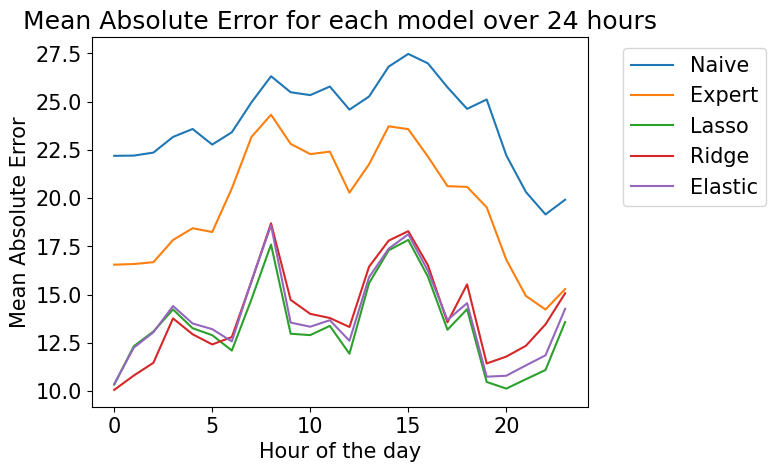

In [41]:
model_names = ["Naive", "Expert", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, MAE_hourly.shape[1]):
    plt.plot(MAE_hourly[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("Mean Absolute Error for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("Mean Absolute Error")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()




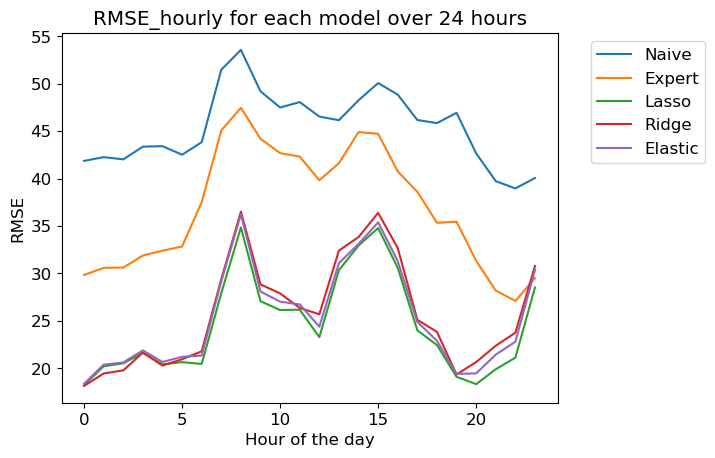

In [128]:
model_names = ["Naive", "Expert", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, RMSE_hourly.shape[1]):
    plt.plot(RMSE_hourly[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("RMSE_hourly for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("RMSE")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [129]:
# Calculate the overall mean MAE for each model
overall_mean_MAE_models = np.mean(MAE_hourly, axis=0)
overall_mean_RMSE_models = np.mean(RMSE_hourly, axis=0)

In [44]:
overall_mean_MAE_models

array([ 0.        , 23.99062022, 19.71763997, 13.40013019, 14.02468851,
       13.81532367])

In [130]:
overall_mean_RMSE_models

array([ 0.        , 45.3902726 , 36.8684865 , 24.57379057, 25.753182  ,
       25.34905473])

["true", "naive", "expert", "expert.readv", "expert.last", "lasso", "ridge", "elastic"]

# Out-of-sample forecast

In [46]:
# naive
for n in range(N_test):
    Y = price_S.iloc[n:D+n]
    days = pd.to_datetime(dates_S[n:D+n], utc=True)

    fc_naive_test = forecast_naive(Y=Y, days=days) #naive
    forecasts_test[n, :, 1] = fc_naive_test["forecasts"]



In [47]:
# expert
for n in range(N_test):
    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    fc_expert_test = forecast_expert(Y=Y, days=days, expert_wd=expert_wd,
                                expert_lags=expert_lags)
    forecasts_test[n, :, 2] = fc_expert_test["forecasts"]




In [48]:
## lasso
for n in range(N_test):
    ## true price for comparing
    forecasts_test[n, :, 0] = price_S.iloc[D + n]

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Lasso model
    fc_lasso_test = forecast_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) # , index_ext=index_ext
    forecasts_test[n, :, 3] = fc_lasso_test["forecasts"]

In [49]:

# Access the dataframes
final_forecast_lasso_test = forecasts_test[-1, :, 5]
final_best_alpha_lasso_test = fc_lasso_test["best_alpha"][-1]
final_best_coefs_df_lasso_test = fc_lasso_test["best_coefs"][-1]

In [125]:
# ridge

for n in range(N_test):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Ridge model
    fc_ridge_test = forecast_ridge(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index) # , index_ext=index_ext
    forecasts_test[n, :, 4] = fc_ridge_test["forecasts"]

In [51]:
# elastic
for n in range(N_test):

    index = np.arange(7+n, D+n)
    Y = price_S.iloc[index]
    days = pd.to_datetime(dates_S[index])
    #Y = price_S.iloc[n:D + n]
    days = pd.to_datetime(dates_S[n:D + n], utc=True)

    # Elastic model
    fc_elastic_test = forecast_sg_lasso(Y=Y, days=days, expert_wd=expert_wd, expert_lags=expert_lags, lambdas=lambdas, 
                              fuel_lags=fuel_lags, output_lags=output_lags, index=index, alpha_ratio=0.5)
    forecasts_test[n, :, 5] = fc_elastic_test["forecasts"]


In [131]:
errors_test = forecasts_test - forecasts_test[:, :, 0:1]
MAE_test = np.nanmean(np.abs(errors_test), axis=0)
RMSE_test = np.sqrt(np.nanmean(errors_test**2, axis=0))


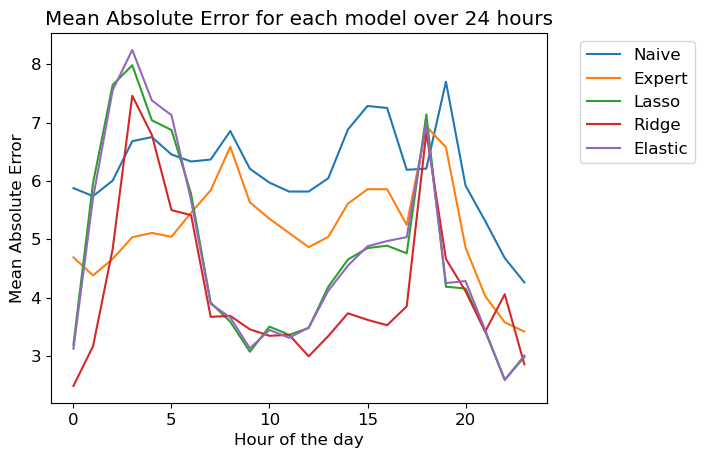

In [107]:
model_names = ["Naive", "Expert", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, MAE_test.shape[1]):
    plt.plot(MAE_test[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("Mean Absolute Error for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("Mean Absolute Error")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

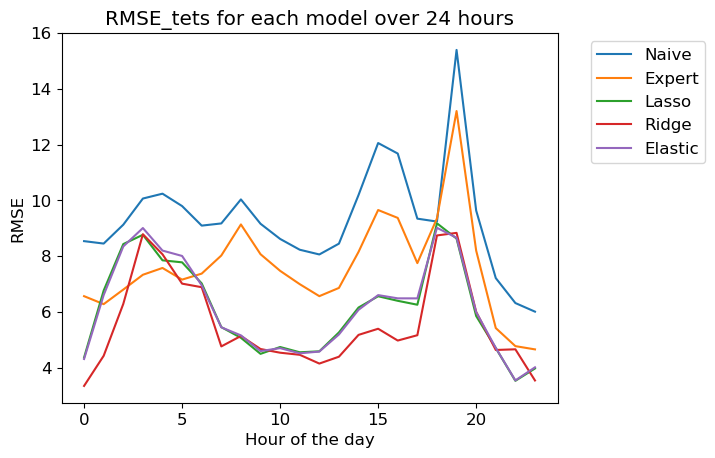

In [132]:
model_names = ["Naive", "Expert", "Lasso", "Ridge", "Elastic"]

# Plot the MAE for each model from columns 1 to 4
for model_idx in range(1, RMSE_test.shape[1]):
    plt.plot(RMSE_test[:, model_idx], label=f'{model_names[model_idx - 1]}')

plt.title("RMSE_tets for each model over 24 hours")
plt.xlabel("Hour of the day")
plt.ylabel("RMSE")

# Move the legend outside the plot frame
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [109]:
# Calculate the overall mean MAE for each model
overall_mean_MAE_models_test = np.mean(MAE_test, axis=0)
overall_mean_RMSE_models_test = np.mean(RMSE_test, axis=0)

In [133]:
overall_mean_RMSE_models_test

array([0.        , 9.34240706, 7.61787903, 6.10289703, 5.52179211,
       6.13686278])

### DM test

In [134]:
from scipy.stats import t

In [135]:
def dm_test(error_a, error_b, hmax=1, power=1):
    # as dm_test with alternative == "less"
    loss_a = (np.abs(error_a)**power).sum(1)**(1/power)
    loss_b = (np.abs(error_b)**power).sum(1)**(1/power)
    delta = loss_a - loss_b
    # estimation of the variance
    delta_var = np.var(delta) / delta.shape[0]
    statistic = delta.mean() / np.sqrt(delta_var)
    delta_length = delta.shape[0]
    k = ((delta_length + 1 - 2 * hmax + (hmax / delta_length)
         * (hmax - 1)) / delta_length)**(1 / 2)
    statistic = statistic * k
    p_value = t.cdf(statistic, df=delta_length-1)

    return {"stat": statistic, "p_val": p_value}


# %% Now test the naive model vs. expert model
dm_test(errors[..., 1], errors[..., 2])


{'stat': 6.344603642473511, 'p_val': 0.9999999998314418}

In [136]:


errors_wo_true = errors[..., 1:]
model_names_wo_true = [str(i) + "_" + model_names[i]
                       for i in range(len(model_names))]

dm_results_df = pd.DataFrame(
    columns=model_names_wo_true, index=model_names_wo_true, dtype=np.float64)

dm_results = {"p_val": dm_results_df.copy(), "t_stat": dm_results_df.copy()}
dm_results["p_val"].loc[:, "type"] = "p_val"
dm_results["t_stat"].loc[:, "type"] = "t_stat"

# Calculate p-values and t-statistics
for model1 in model_names_wo_true:
    for model2 in model_names_wo_true:
        if model1 != model2:
            errors1 = errors_wo_true[:, model_names_wo_true.index(model1)]
            errors2 = errors_wo_true[:, model_names_wo_true.index(model2)]
            
            # Find common non-NaN indices
            valid_indices = ~np.isnan(errors1) & ~np.isnan(errors2)
            
            if np.any(valid_indices):  # Check if there are common non-NaN values
                errors1_valid = errors1[valid_indices]
                errors2_valid = errors2[valid_indices]
                
                # Calculate t-statistics and p-values
                t_stat, p_val = ttest_rel(errors1_valid, errors2_valid, axis=0)
                
                # Store the mean values in the result DataFrame
                dm_results["t_stat"].loc[model1, model2] = np.mean(t_stat)
                dm_results["p_val"].loc[model1, model2] = np.mean(p_val)



In [137]:
data = dm_results["p_val"].iloc[:, :-1]
data

0_Naive      1_Expert       2_Lasso       3_Ridge  \
0_Naive             NaN  6.651078e-40  4.314619e-23  7.291876e-32   
1_Expert   6.651078e-40           NaN  7.168996e-01  2.570152e-10   
2_Lasso    4.314619e-23  7.168996e-01           NaN  4.647163e-14   
3_Ridge    7.291876e-32  2.570152e-10  4.647163e-14           NaN   
4_Elastic  3.241988e-11  8.417116e-01  9.845782e-01  7.238094e-20   

              4_Elastic  
0_Naive    3.241988e-11  
1_Expert   8.417116e-01  
2_Lasso    9.845782e-01  
3_Ridge    7.238094e-20  
4_Elastic           NaN

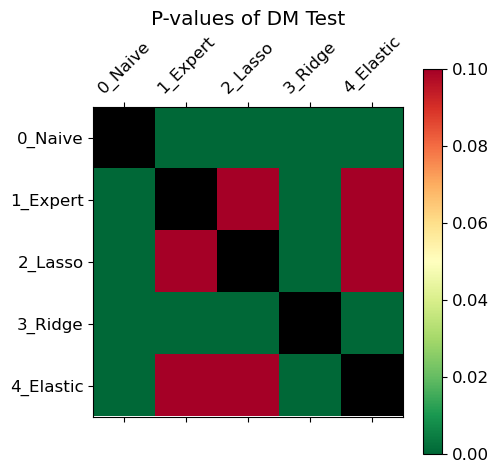

In [138]:
import matplotlib.pyplot as plt
import numpy as np


data = dm_results["p_val"].iloc[:, :-1]

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(5, 5))

cmap = plt.cm.RdYlGn.reversed()
cmap.set_bad(color='black')


im = ax.matshow(data, cmap=cmap, vmin=0, vmax=0.1)


ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[0]))
ax.set_xticklabels(model_names_wo_true, rotation=45)
ax.set_yticklabels(model_names_wo_true)

# Add colorbar
cb = plt.colorbar(im)

# Set title
plt.title("P-values of DM Test")

# Show the plot
plt.show()

# Plot results

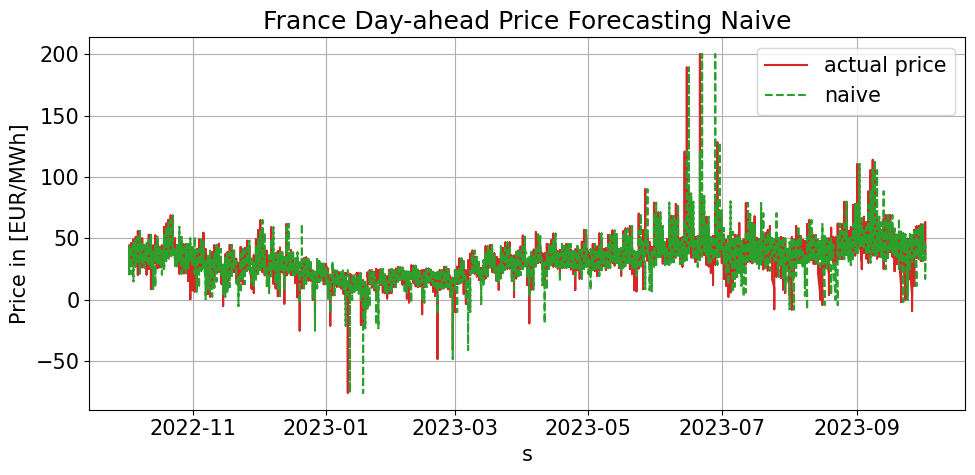

In [141]:

df = pd.DataFrame({
    "actual": forecasts_test[:, :, 0].flatten(),
    "naive": forecasts_test[:, :, 1].flatten(),
    "expert": forecasts_test[:, :, 2].flatten(),
    "lasso": forecasts_test[:, :, 3].flatten(),
    "ridge": forecasts_test[:, :, 4].flatten(),
    "elastic": forecasts_test[:, :, 5].flatten()
}, index=np.repeat(oos_dates_test, 24))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))


actual_series = df["actual"]
naive_series = df["naive"]


# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(naive_series, linestyle='--', color='tab:green')


plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Naive")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'naive'])
plt.show()

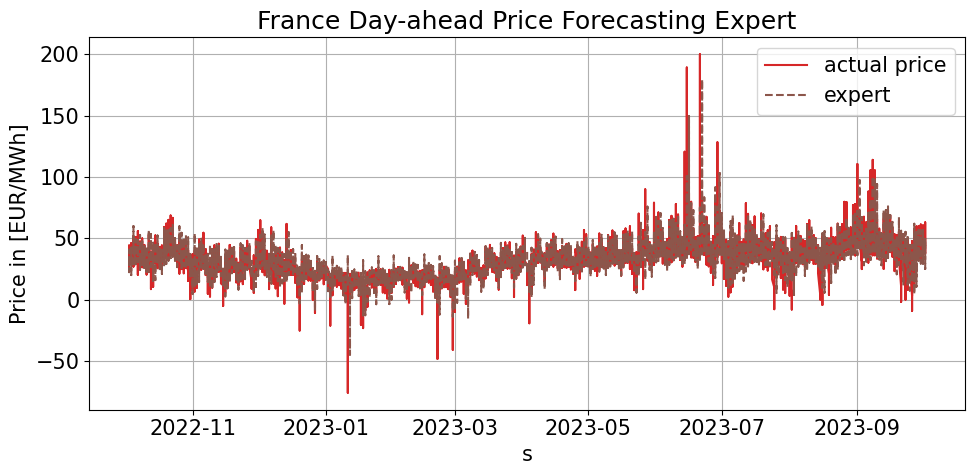

In [142]:
actual_series = df["actual"]
expert_series = df["expert"]

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))
# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(expert_series, linestyle='--', color='tab:brown')

plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Expert")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'expert'])

plt.show()

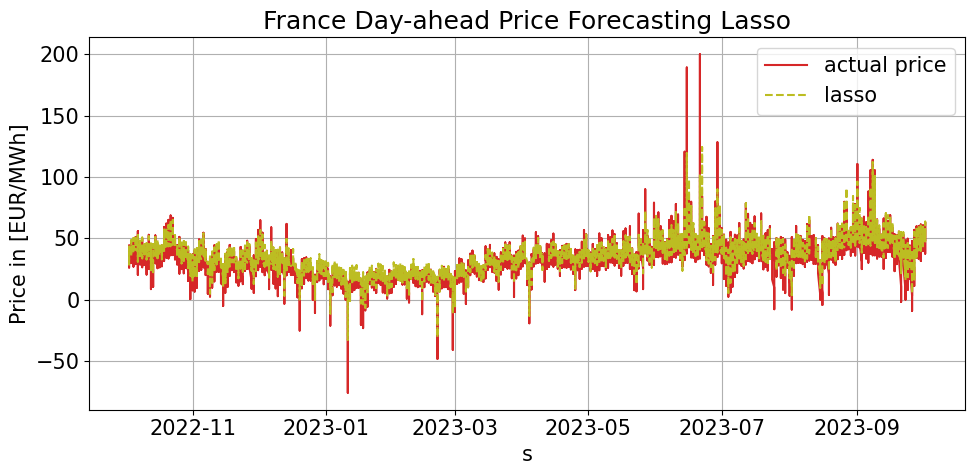

In [145]:

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# Extract the desired series
actual_series = df["actual"]
lasso_series = df["lasso"]


# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(lasso_series, linestyle='--', color='tab:olive')


plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Lasso")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'lasso'])
#plt.savefig("out/illustration_forecast.pdf")
plt.show()

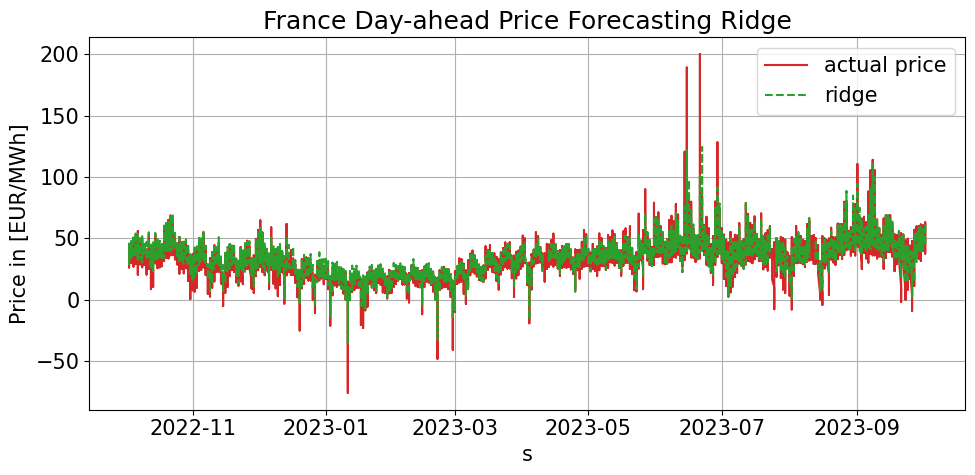

In [144]:

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# # Extract the desired series
# actual_series = df["actual"]
ridge_series = df["ridge"]


# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(ridge_series, linestyle='--', color='tab:green')


plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Ridge")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'ridge'])
#plt.savefig("out/illustration_forecast.pdf")
plt.show()

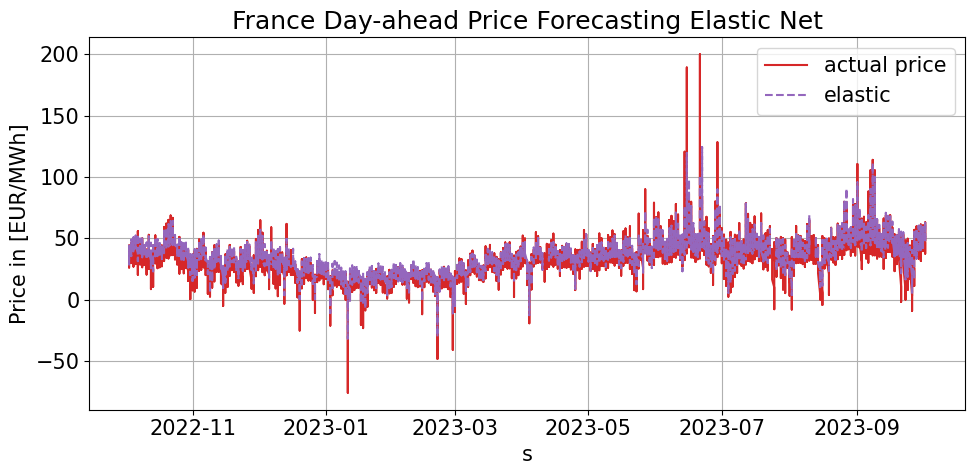

In [146]:

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 5))

# Extract the desired series
actual_series = df["actual"]
elastic_series = df["elastic"]

# Plot the series
plt.plot(actual_series, linestyle='-', color='tab:red')
plt.plot(elastic_series, linestyle='--', color='tab:purple')

plt.ylabel("Price in [EUR/MWh]")
plt.xlabel("s")
plt.title("France Day-ahead Price Forecasting Elastic Net")
plt.tight_layout()
plt.grid()
plt.legend(['actual price', 'elastic'])
plt.show()